# 4.5 Factor Analysis on Financial and Economic Time Series

Factor Analysis and Principal Component Analysis on Financial and Economic Time Series

In [1]:
# If you're running this on Colab, make sure to install the following packages using pip.
# On you're own computer, I recommend using conda or mamba.

# !pip install pandas-datareader
# !pip install yfinance

# !conda install pandas-datareader
# !conda install yfinance

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import yfinance as yf
import pandas_datareader as pdr
import sklearn.decomposition
import statsmodels.multivariate.pca

In [3]:
import config
DATA_DIR = config.DATA_DIR

## Downloading macroeconomic and financial data from FRED

In [4]:
fred_series_long_names = {
    'BAMLH0A0HYM2': 'ICE BofA US High Yield Index Option-Adjusted Spread',
    'NASDAQCOM': 'NASDAQ Composite Index',
    'RIFSPPFAAD90NB': '90-Day AA Financial Commercial Paper Interest Rate',
    'TB3MS': '3-Month Treasury Bill Secondary Market Rate',
    'DGS10': 'Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity',
    'VIXCLS': 'CBOE Volatility Index: VIX',
}

In [5]:
fred_series_short_names = {
    'BAMLH0A0HYM2': 'High Yield Index OAS',
    'NASDAQCOM': 'NASDAQ',
    'RIFSPPFAAD90NB': '90-Day AA Fin CP',
    'TB3MS': '3-Month T-Bill',
    'DGS10': '10-Year Treasury',
    'VIXCLS': 'VIX',
}

In [6]:
start_date = pd.to_datetime('1980-01-01') 
end_date = pd.to_datetime('today') 

In [7]:
df = pdr.get_data_fred(fred_series_short_names.keys(), start=start_date, end=end_date)

First, an aside about reading and writing data to disk.

In [8]:
df.to_csv(DATA_DIR / 'fred_panel.csv')

In [9]:
dff = pd.read_csv(DATA_DIR / 'fred_panel.csv')

In [10]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12155 entries, 0 to 12154
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            12155 non-null  object 
 1   BAMLH0A0HYM2    7472 non-null   float64
 2   NASDAQCOM       11500 non-null  float64
 3   RIFSPPFAAD90NB  6606 non-null   float64
 4   TB3MS           547 non-null    float64
 5   DGS10           11405 non-null  float64
 6   VIXCLS          8994 non-null   float64
dtypes: float64(6), object(1)
memory usage: 664.9+ KB


In [11]:
dff = pd.read_csv(DATA_DIR / 'fred_panel.csv', parse_dates=['DATE'])

In [12]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12155 entries, 0 to 12154
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            12155 non-null  datetime64[ns]
 1   BAMLH0A0HYM2    7472 non-null   float64       
 2   NASDAQCOM       11500 non-null  float64       
 3   RIFSPPFAAD90NB  6606 non-null   float64       
 4   TB3MS           547 non-null    float64       
 5   DGS10           11405 non-null  float64       
 6   VIXCLS          8994 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 664.9 KB


In [13]:
dff = dff.set_index('DATE')

In [14]:
df.to_parquet(DATA_DIR / 'fred_panel.parquet')

In [15]:
df = pd.read_parquet(DATA_DIR / 'fred_panel.parquet')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12155 entries, 1980-01-01 to 2025-08-14
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BAMLH0A0HYM2    7472 non-null   float64
 1   NASDAQCOM       11500 non-null  float64
 2   RIFSPPFAAD90NB  6606 non-null   float64
 3   TB3MS           547 non-null    float64
 4   DGS10           11405 non-null  float64
 5   VIXCLS          8994 non-null   float64
dtypes: float64(6)
memory usage: 664.7 KB


In [17]:
df

,BAMLH0A0HYM2,NASDAQCOM,RIFSPPFAAD90NB,TB3MS,DGS10,VIXCLS
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,12.0,NaN,NaN
1980-01-02,NaN,148.17,NaN,NaN,10.50,NaN
1980-01-03,NaN,145.97,NaN,NaN,10.60,NaN
1980-01-04,NaN,148.02,NaN,NaN,10.66,NaN
1980-01-07,NaN,148.62,NaN,NaN,10.63,NaN
...,...,...,...,...,...,...
2025-08-08,2.94,21450.02,4.21,NaN,4.27,15.15
2025-08-11,2.94,21385.40,4.23,NaN,4.27,16.25
2025-08-12,2.93,21681.90,4.20,NaN,4.29,14.73


## Cleaning Data


In [18]:
df = dff.rename(columns=fred_series_short_names)
df

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,12.0,NaN,NaN
1980-01-02,NaN,148.17,NaN,NaN,10.50,NaN
1980-01-03,NaN,145.97,NaN,NaN,10.60,NaN
1980-01-04,NaN,148.02,NaN,NaN,10.66,NaN
1980-01-07,NaN,148.62,NaN,NaN,10.63,NaN
...,...,...,...,...,...,...
2025-08-08,2.94,21450.02,4.21,NaN,4.27,15.15
2025-08-11,2.94,21385.40,4.23,NaN,4.27,16.25
2025-08-12,2.93,21681.90,4.20,NaN,4.29,14.73


Balanced panel? Mixed frequencies?

In [19]:
df['3-Month T-Bill'].dropna()

DATE
1980-01-01    12.00
1980-02-01    12.86
1980-03-01    15.20
1980-04-01    13.20
1980-05-01     8.58
              ...  
2025-03-01     4.20
2025-04-01     4.21
2025-05-01     4.25
2025-06-01     4.23
2025-07-01     4.25
Name: 3-Month T-Bill, Length: 547, dtype: float64

Find a daily version of this series. See here: https://fred.stlouisfed.org/categories/22

We will end up using this series: https://fred.stlouisfed.org/series/DTB3

In [20]:
fred_series_short_names = {
    'BAMLH0A0HYM2': 'High Yield Index OAS',
    'NASDAQCOM': 'NASDAQ',
    'RIFSPPFAAD90NB': '90-Day AA Fin CP',
    'DTB3': '3-Month T-Bill',
    'DGS10': '10-Year Treasury',
    'VIXCLS': 'VIX',
}
df = pdr.get_data_fred(fred_series_short_names.keys(), start=start_date, end=end_date)
df = df.rename(columns=fred_series_short_names)

In [21]:
df

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,148.17,NaN,12.17,10.50,NaN
1980-01-03,NaN,145.97,NaN,12.10,10.60,NaN
1980-01-04,NaN,148.02,NaN,12.10,10.66,NaN
1980-01-07,NaN,148.62,NaN,11.86,10.63,NaN
...,...,...,...,...,...,...
2025-08-08,2.94,21450.02,4.21,4.14,4.27,15.15
2025-08-11,2.94,21385.40,4.23,4.15,4.27,16.25
2025-08-12,2.93,21681.90,4.20,4.14,4.29,14.73


In [22]:
df.dropna()

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1997-01-02,3.06,1280.70,5.35,5.05,6.54,21.14
1997-01-03,3.09,1310.68,5.35,5.04,6.52,19.13
1997-01-06,3.10,1316.40,5.34,5.05,6.54,19.89
1997-01-07,3.10,1327.73,5.33,5.02,6.57,19.35
1997-01-08,3.07,1320.35,5.31,5.02,6.60,20.24
...,...,...,...,...,...,...
2025-08-07,2.95,21242.70,4.24,4.14,4.23,16.57
2025-08-08,2.94,21450.02,4.21,4.14,4.27,15.15
2025-08-11,2.94,21385.40,4.23,4.15,4.27,16.25


## Transforming and Normalizing the data

What is transformation and normalization? Are these different things?

 - Why would one transform data? What is feature engineering?
 - What is normalization?

What does stationarity mean? See the the following plots. Some of these variable are stationary. Other are not? Why is this a problem?

<Axes: xlabel='DATE'>

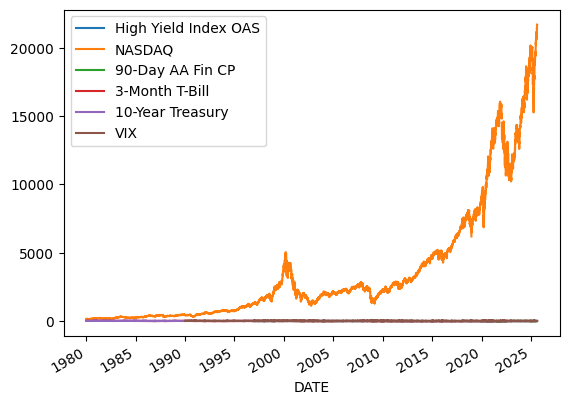

In [23]:
df.plot()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11999 entries, 1980-01-01 to 2025-08-14
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   High Yield Index OAS  7472 non-null   float64
 1   NASDAQ                11500 non-null  float64
 2   90-Day AA Fin CP      6606 non-null   float64
 3   3-Month T-Bill        11405 non-null  float64
 4   10-Year Treasury      11405 non-null  float64
 5   VIX                   8994 non-null   float64
dtypes: float64(6)
memory usage: 656.2 KB


<Axes: xlabel='DATE'>

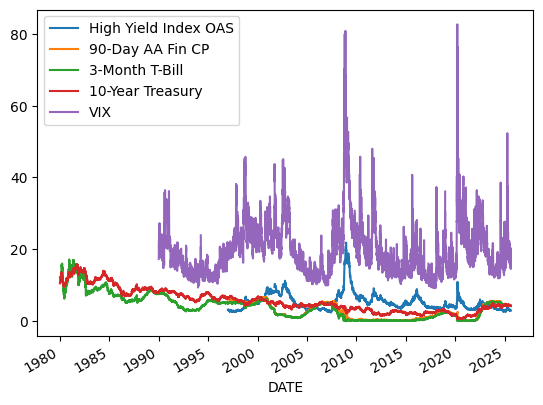

In [25]:
df.drop(columns=['NASDAQ']).plot()

Let's try some transformations like those used in the OFR Financial Stress Index: https://www.financialresearch.gov/financial-stress-index/files/indicators/index.html

In [26]:
dfn = pd.DataFrame().reindex_like(df)
dfn

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-08-08,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-11,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-12,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df['NASDAQ'].rolling(250).mean()

DATE
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-07   NaN
              ..
2025-08-08   NaN
2025-08-11   NaN
2025-08-12   NaN
2025-08-13   NaN
2025-08-14   NaN
Name: NASDAQ, Length: 11999, dtype: float64

In [28]:
df = df.dropna()

In [29]:
df['NASDAQ'].rolling(250).mean()

DATE
1997-01-02            NaN
1997-01-03            NaN
1997-01-06            NaN
1997-01-07            NaN
1997-01-08            NaN
                 ...     
2025-08-07    17255.97032
2025-08-08    17287.24620
2025-08-11    17318.88928
2025-08-12    17352.34916
2025-08-13    17386.03860
Name: NASDAQ, Length: 6585, dtype: float64

In [30]:
# 'High Yield Index OAS': Leave as is
dfn['High Yield Index OAS'] = df['High Yield Index OAS']
dfn['CP - Treasury Spread, 3m'] = df['90-Day AA Fin CP'] - df['3-Month T-Bill']
# 'NASDAQ':  # We're using something different, but still apply rolling mean transformation
dfn['NASDAQ'] = np.log(df['NASDAQ']) - np.log(df['NASDAQ'].rolling(250).mean())
dfn['10-Year Treasury'] = df['10-Year Treasury'] - df['10-Year Treasury'].rolling(250).mean()
# 'VIX': Leave as is
dfn['VIX'] = df['VIX']

In [31]:
dfn = dfn.drop(columns=['90-Day AA Fin CP', '3-Month T-Bill'])
dfn = dfn.dropna()

In [32]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6336 entries, 1998-01-05 to 2025-08-13
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   High Yield Index OAS      6336 non-null   float64
 1   NASDAQ                    6336 non-null   float64
 2   10-Year Treasury          6336 non-null   float64
 3   VIX                       6336 non-null   float64
 4   CP - Treasury Spread, 3m  6336 non-null   float64
dtypes: float64(5)
memory usage: 297.0 KB


We finished with our transformations. Now, let's normalize. First, why is it important?

<Axes: xlabel='DATE'>

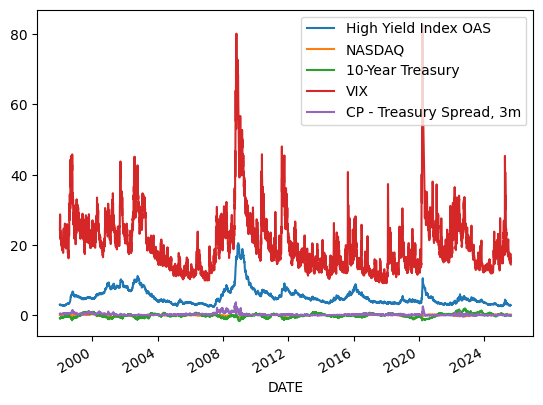

In [33]:
dfn.plot()

Now, normalize each column,
$$
z = \frac{x - \bar x}{\text{std}(x)}
$$

In [34]:
dfn = (dfn - dfn.mean()) / dfn.std()

<Axes: xlabel='DATE'>

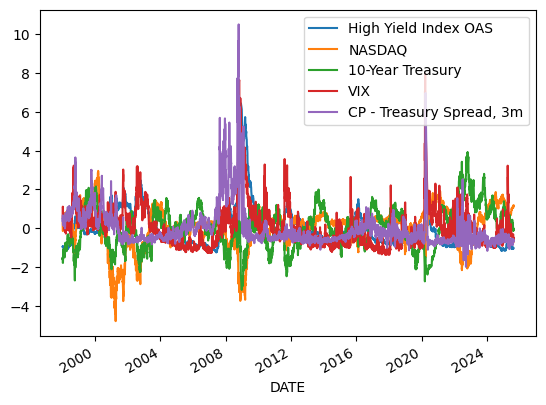

In [35]:
dfn.plot()

In [36]:
def pca(dfn, module='scikitlearn'):
    if module == 'statsmodels':
        _pc1, _loadings, projection, rsquare, _, _, _ = statsmodels.multivariate.pca.pca(dfn,
            ncomp=1, standardize=True, demean=True, normalize=True, gls=False,
            weights=None, method='svd')
        _loadings = _loadings['comp_0']
        loadings = np.std(_pc1) * _loadings
        pc1 = _pc1 / np.std(_pc1)
        pc1 = pc1.rename(columns={'comp_0':'PC1'})['PC1']

    elif module == 'scikitlearn':
        pca = sklearn.decomposition.PCA(n_components=1)
        _pc1 = pd.Series(pca.fit_transform(dfn)[:,0], index=dfn.index, name='PC1')
        _loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
        _loadings = pd.Series(_loadings[:,0], index=dfn.columns)

        loadings = np.std(_pc1) * _loadings
        pc1 = _pc1 / np.std(_pc1)
        pc1.name = 'PC1'
    else:
        raise ValueError



    loadings.name = "loadings"

    return pc1, loadings

def stacked_plot(df, filename=None):
    """
    df=category_contributions
    # category_contributions.sum(axis=1).plot()
    """

    df_pos = df[df >= 0]
    df_neg = df[df < 0]

    alpha = .3
    linewidth = .5

    ax = df_pos.plot.area(alpha=alpha, linewidth=linewidth, legend=False)
    pc1 = df.sum(axis=1)
    pc1.name = 'pc1'
    pc1.plot(color="Black", label='pc1', linewidth=1)


    plt.legend()
    ax.set_prop_cycle(None)
    df_neg.plot.area(alpha=alpha, ax=ax, linewidth=linewidth, legend=False, ylim=(-3,3))
    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale()
    # ax.set_ylabel('Standard Deviations')
    # ax.set_ylim(-3,4)
    # ax.set_ylim(-30,30)

    if not (filename is None):
        filename = Path(filename)
        figure = plt.gcf() # get current figure
        figure.set_size_inches(8, 6)
        plt.savefig(filename, dpi=300)


In [37]:
pc1, loadings = pca(dfn, module='scikitlearn')

<Axes: xlabel='DATE'>

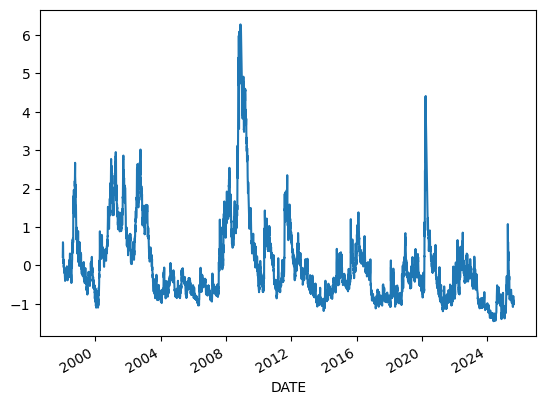

In [38]:
pc1.plot()

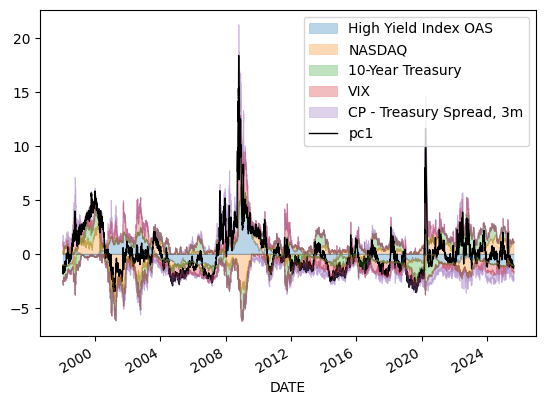

In [39]:
stacked_plot(dfn)

Let's compare solutions from two different packages

In [40]:
def root_mean_squared_error(sa, sb):
    return np.sqrt(np.mean((sa - sb)**2))

pc1_sk, loadings_sk = pca(dfn, module='scikitlearn')
pc1_sm, loadings_sm = pca(dfn, module='statsmodels')
root_mean_squared_error(pc1_sm, pc1_sk)

/opt/homebrew/Caskroom/mambaforge/base/envs/finm/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


np.float64(4.679411434922667e-16)

## Factor Analysis of a Panel of Stock Returns?

In [41]:
# Download sample data for multiple tickers
# Note: yfinance may return different structures depending on version and number of tickers
sample = yf.download("SPY AAPL MSFT", start="2017-01-01", end="2017-04-30", progress=False)

/var/folders/l3/tj6vb0ld2ys1h939jz0qrfrh0000gn/T/ipykernel_5885/673421897.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sample = yf.download("SPY AAPL MSFT", start="2017-01-01", end="2017-04-30", progress=False)


In [42]:
# Let's examine the structure of the downloaded data
print("Sample columns:", sample.columns.tolist() if hasattr(sample, 'columns') else 'No columns attribute')
print("Sample shape:", sample.shape if hasattr(sample, 'shape') else 'No shape attribute')
if hasattr(sample, 'columns') and isinstance(sample.columns, pd.MultiIndex):
    print("Column levels:", sample.columns.levels)
    print("First level values:", sample.columns.levels[0].tolist())


Sample columns: [('Close', 'AAPL'), ('Close', 'MSFT'), ('Close', 'SPY'), ('High', 'AAPL'), ('High', 'MSFT'), ('High', 'SPY'), ('Low', 'AAPL'), ('Low', 'MSFT'), ('Low', 'SPY'), ('Open', 'AAPL'), ('Open', 'MSFT'), ('Open', 'SPY'), ('Volume', 'AAPL'), ('Volume', 'MSFT'), ('Volume', 'SPY')]
Sample shape: (81, 15)
Column levels: [['Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'MSFT', 'SPY']]
First level values: ['Close', 'High', 'Low', 'Open', 'Volume']


In [43]:
sample

Price           Close                              High             \
Ticker           AAPL       MSFT         SPY       AAPL       MSFT   
Date                                                                 
2017-01-03  26.796825  56.497421  196.117371  26.838353  56.732149   
2017-01-04  26.766844  56.244614  197.284134  26.879892  56.650876   
2017-01-05  26.902958  56.244614  197.127396  26.960635  56.569623   
2017-01-06  27.202881  56.732140  197.832642  27.260558  57.012010   
2017-01-09  27.452047  56.551567  197.179642  27.553560  56.948803   
...               ...        ...         ...        ...        ...   
2017-04-24  33.282696  61.335896  207.403244  33.354525  61.453976   
2017-04-25  33.488934  61.690125  208.610046  33.574665  61.799120   
2017-04-26  33.291969  61.608391  208.478851  33.505145  62.044360   
2017-04-27  33.317463  62.008022  208.653793  33.403198  62.107933   
2017-04-28  33.285015  62.180584  208.199036  33.435628  62.798212   

Price                         Low                              Open  \
Ticker             SPY       AAPL       MSFT         SPY       AAPL   
Date                                                                  
2017-01-03  196.631083  26.476140  56.091159  194.933213  26.716078   
2017-01-04  197.432152  26.704553  56.082109  196.439550  26.727624   
2017-01-05  197.284129  26.718390  56.000856  196.326349  26.743768   
2017-01-06  198.302816  26.870660  56.009898  196.692008  26.942179   
2017-01-09  197.710772  27.209804  56.461288  197.144806  27.212110   
...                ...        ...        ...         ...        ...   
2017-04-24  207.613127  33.176108  60.945336  205.120820  33.250257   
2017-04-25  208.959838  33.336005  61.399476  207.962918  33.345275   
2017-04-26  209.467031  33.222459  61.417654  208.435137  33.475022   
2017-04-27  208.959858  33.206243  61.381316  208.111599  33.347586   
2017-04-28  208.942346  33.196968  61.481214  208.067854  33.386968   

Price                                 Volume                       
Ticker           MSFT         SPY       AAPL      MSFT        SPY  
Date                                                               
2017-01-03  56.687009  195.943219  115127600  20694100   91366500  
2017-01-04  56.407118  196.448252   84472400  21340000   78744400  
2017-01-05  56.145305  197.014213   88774400  24876000   78379000  
2017-01-06  56.244625  197.240556  127007600  19922900   71559900  
2017-01-09  56.659902  197.571456  134247600  20382700   46939700  
...               ...         ...        ...       ...        ...  
2017-04-24  61.290486  207.411984   68537200  29770000  119209900  
2017-04-25  61.671962  208.050372   75486000  30242700   76698300  
2017-04-26  61.835460  208.575046   80164800  26190800   84702500  
2017-04-27  61.899034  208.802455   56985200  34971000   57410300  
2017-04-28  62.589312  208.916112   83441600  39548800   63532800  

[81 rows x 15 columns]

In [44]:
# When downloading multiple tickers, yfinance returns a DataFrame with MultiIndex columns
# The first level is the data type (e.g., 'Adj Close'), the second level is the ticker
# Display the adjusted close prices for all tickers
adj_close_data = sample['Adj Close'] if 'Adj Close' in sample.columns.get_level_values(0) else sample
adj_close_data

Price           Close                              High             \
Ticker           AAPL       MSFT         SPY       AAPL       MSFT   
Date                                                                 
2017-01-03  26.796825  56.497421  196.117371  26.838353  56.732149   
2017-01-04  26.766844  56.244614  197.284134  26.879892  56.650876   
2017-01-05  26.902958  56.244614  197.127396  26.960635  56.569623   
2017-01-06  27.202881  56.732140  197.832642  27.260558  57.012010   
2017-01-09  27.452047  56.551567  197.179642  27.553560  56.948803   
...               ...        ...         ...        ...        ...   
2017-04-24  33.282696  61.335896  207.403244  33.354525  61.453976   
2017-04-25  33.488934  61.690125  208.610046  33.574665  61.799120   
2017-04-26  33.291969  61.608391  208.478851  33.505145  62.044360   
2017-04-27  33.317463  62.008022  208.653793  33.403198  62.107933   
2017-04-28  33.285015  62.180584  208.199036  33.435628  62.798212   

Price                         Low                              Open  \
Ticker             SPY       AAPL       MSFT         SPY       AAPL   
Date                                                                  
2017-01-03  196.631083  26.476140  56.091159  194.933213  26.716078   
2017-01-04  197.432152  26.704553  56.082109  196.439550  26.727624   
2017-01-05  197.284129  26.718390  56.000856  196.326349  26.743768   
2017-01-06  198.302816  26.870660  56.009898  196.692008  26.942179   
2017-01-09  197.710772  27.209804  56.461288  197.144806  27.212110   
...                ...        ...        ...         ...        ...   
2017-04-24  207.613127  33.176108  60.945336  205.120820  33.250257   
2017-04-25  208.959838  33.336005  61.399476  207.962918  33.345275   
2017-04-26  209.467031  33.222459  61.417654  208.435137  33.475022   
2017-04-27  208.959858  33.206243  61.381316  208.111599  33.347586   
2017-04-28  208.942346  33.196968  61.481214  208.067854  33.386968   

Price                                 Volume                       
Ticker           MSFT         SPY       AAPL      MSFT        SPY  
Date                                                               
2017-01-03  56.687009  195.943219  115127600  20694100   91366500  
2017-01-04  56.407118  196.448252   84472400  21340000   78744400  
2017-01-05  56.145305  197.014213   88774400  24876000   78379000  
2017-01-06  56.244625  197.240556  127007600  19922900   71559900  
2017-01-09  56.659902  197.571456  134247600  20382700   46939700  
...               ...         ...        ...       ...        ...  
2017-04-24  61.290486  207.411984   68537200  29770000  119209900  
2017-04-25  61.671962  208.050372   75486000  30242700   76698300  
2017-04-26  61.835460  208.575046   80164800  26190800   84702500  
2017-04-27  61.899034  208.802455   56985200  34971000   57410300  
2017-04-28  62.589312  208.916112   83441600  39548800   63532800  

[81 rows x 15 columns]

In [45]:
tickers = [
    'AAPL','ABBV','ABT','ACN','ADP','ADSK','AES','AET','AFL','AMAT','AMGN','AMZN','APA',
    'APHA','APD','APTV','ARE','ASML','ATVI','AXP','BA','BAC','BAX','BDX','BIIB','BK',
    'BKNG','BMY','BRKB','BRK.A','COG','COST','CPB','CRM','CSCO','CVS','DAL','DD','DHR',
    'DIS','DOW','DUK','EMR','EPD','EQT','ESRT','EXPD','FFIV','FLS','FLT','FRT','GE',
    'GILD','GOOGL','GOOG','GS','HAL','HD','HON','IBM','INTC','IP','JNJ','JPM','KEY',
    'KHC','KIM','KO','LLY','LMT','LOW','MCD','MCHP','MDT','MMM','MO','MRK','MSFT',
    'MTD','NEE','NFLX','NKE','NOV','ORCL','OXY','PEP','PFE','PG','RTN','RTX','SBUX',
    'SHW','SLB','SO','SPG','STT','T','TGT','TXN','UNH','UPS','USB','UTX','V','VZ',
    'WMT','XOM',
]

In [46]:
all_tickers = " ".join(tickers)
all_tickers

'AAPL ABBV ABT ACN ADP ADSK AES AET AFL AMAT AMGN AMZN APA APHA APD APTV ARE ASML ATVI AXP BA BAC BAX BDX BIIB BK BKNG BMY BRKB BRK.A COG COST CPB CRM CSCO CVS DAL DD DHR DIS DOW DUK EMR EPD EQT ESRT EXPD FFIV FLS FLT FRT GE GILD GOOGL GOOG GS HAL HD HON IBM INTC IP JNJ JPM KEY KHC KIM KO LLY LMT LOW MCD MCHP MDT MMM MO MRK MSFT MTD NEE NFLX NKE NOV ORCL OXY PEP PFE PG RTN RTX SBUX SHW SLB SO SPG STT T TGT TXN UNH UPS USB UTX V VZ WMT XOM'

In [47]:
data = yf.download(all_tickers, start="1980-01-01", end=pd.to_datetime('today'), progress=False)

/var/folders/l3/tj6vb0ld2ys1h939jz0qrfrh0000gn/T/ipykernel_5885/3096157927.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(all_tickers, start="1980-01-01", end=pd.to_datetime('today'), progress=False)



9 Failed downloads:


['BRK.A', 'FLT', 'COG', 'APHA', 'RTN', 'UTX', 'BRKB', 'ATVI']: YFTzMissingError('possibly delisted; no timezone found')


['MRK']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


In [48]:
data

Price      Adj Close                                           Close  ...  \
Ticker          APHA ATVI BRK.A BRKB COG FLT MRK RTN UTX        AAPL  ...   
Date                                                                  ...   
1980-01-02       NaN  NaN   NaN  NaN NaN NaN NaN NaN NaN         NaN  ...   
1980-01-03       NaN  NaN   NaN  NaN NaN NaN NaN NaN NaN         NaN  ...   
1980-01-04       NaN  NaN   NaN  NaN NaN NaN NaN NaN NaN         NaN  ...   
1980-01-07       NaN  NaN   NaN  NaN NaN NaN NaN NaN NaN         NaN  ...   
1980-01-08       NaN  NaN   NaN  NaN NaN NaN NaN NaN NaN         NaN  ...   
...              ...  ...   ...  ...  ..  ..  ..  ..  ..         ...  ...   
2025-08-11       NaN  NaN   NaN  NaN NaN NaN NaN NaN NaN  227.179993  ...   
2025-08-12       NaN  NaN   NaN  NaN NaN NaN NaN NaN NaN  229.649994  ...   
2025-08-13       NaN  NaN   NaN  NaN NaN NaN NaN NaN NaN  233.330002  ...   
2025-08-14       NaN  NaN   NaN  NaN NaN NaN NaN NaN NaN  232.779999  ...   
2025-08-15       NaN  NaN   NaN  NaN NaN NaN NaN NaN NaN  231.294998  ...   

Price        Volume                                                     \
Ticker          TGT        TXN         UNH         UPS         USB UTX   
Date                                                                     
1980-01-02  3691200  3796800.0         NaN         NaN     21600.0 NaN   
1980-01-03  1468800  3134400.0         NaN         NaN     39600.0 NaN   
1980-01-04  3206400  1195200.0         NaN         NaN     10800.0 NaN   
1980-01-07   422400  2068800.0         NaN         NaN     36000.0 NaN   
1980-01-08   451200  5414400.0         NaN         NaN     72000.0 NaN   
...             ...        ...         ...         ...         ...  ..   
2025-08-11  5020200  6457800.0  11779500.0   8701400.0   7201900.0 NaN   
2025-08-12  6593800  9961500.0  12171800.0   7308600.0   8836600.0 NaN   
2025-08-13  7364700  4966300.0  19480300.0  13633200.0  10438100.0 NaN   
2025-08-14  4985000  3916400.0  22987500.0  12455700.0   6181100.0 NaN   
2025-08-15  4576323        NaN  61957831.0         NaN         NaN NaN   

Price                                                      
Ticker              V          VZ         WMT         XOM  
Date                                                       
1980-01-02        NaN         NaN   2073600.0   6622400.0  
1980-01-03        NaN         NaN   4608000.0   7222400.0  
1980-01-04        NaN         NaN   2764800.0   4780800.0  
1980-01-07        NaN         NaN   1228800.0   8331200.0  
1980-01-08        NaN         NaN   5913600.0   8048000.0  
...               ...         ...         ...         ...  
2025-08-11  5715800.0  12914900.0  12856700.0  13570700.0  
2025-08-12  5682800.0  12469300.0  17915300.0  14109400.0  
2025-08-13  5693400.0  14327700.0  19398500.0  17958700.0  
2025-08-14  6223200.0  10580600.0  10851800.0  13677600.0  
2025-08-15        NaN         NaN         NaN         NaN  

[11500 rows x 544 columns]

<Axes: xlabel='Date'>

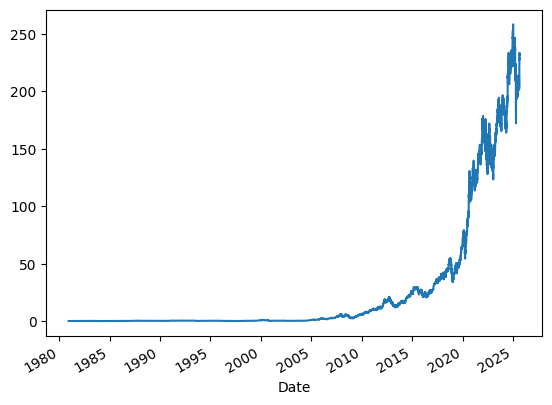

In [49]:
data['Close']['AAPL'].plot()

In [50]:
cols_with_many_nas = [
    "BRK.A",
    "APHA",
    "UTX",
    "RTN",
    "COG",
    "BRKB",
    "ATVI",
    "FLT",
    "DOW",
    "KHC",
    "V",
    "APTV",
    "ABBV",
    "ESRT",
]
df = data['Close']
print(f"Initial shape: {df.shape}")
df = df.drop(columns=cols_with_many_nas, errors='ignore')
print(f"After dropping columns: {df.shape}")
df = df.dropna()
print(f"After first dropna: {df.shape}")
df = df.pct_change()
print(f"After pct_change: {df.shape}")
df = df.dropna()
print(f"Final shape: {df.shape}")

# If DataFrame is empty, use a smaller date range or fewer tickers
if df.empty:
    print("DataFrame is empty! Trying with fewer tickers and recent data...")
    simple_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
    data = yf.download(" ".join(simple_tickers), start="2020-01-01", end=pd.to_datetime('today'), progress=False)
    df = data['Close'].pct_change().dropna()
    print(f"New shape with simple tickers: {df.shape}")


Initial shape: (11500, 107)
After dropping columns: (11500, 93)
After first dropna: (0, 93)
After pct_change: (0, 93)
Final shape: (0, 93)
DataFrame is empty! Trying with fewer tickers and recent data...


/var/folders/l3/tj6vb0ld2ys1h939jz0qrfrh0000gn/T/ipykernel_5885/809774618.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(" ".join(simple_tickers), start="2020-01-01", end=pd.to_datetime('today'), progress=False)


New shape with simple tickers: (1412, 5)


In [51]:
df.columns

Index(['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA'], dtype='object', name='Ticker')

<Axes: xlabel='Date'>

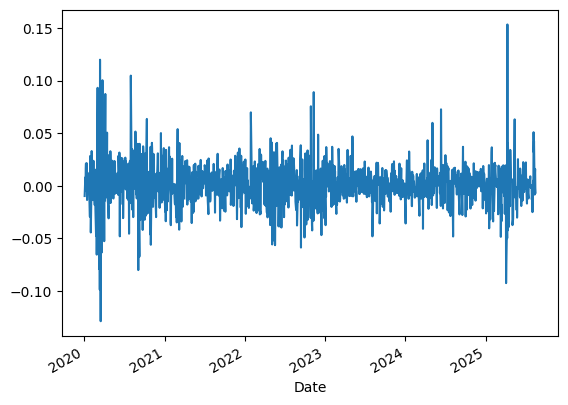

In [52]:
df['AAPL'].plot()

In [53]:
if not df.empty:
    pc1, loadings = pca(df, module='scikitlearn')
    print(f"PCA completed successfully. PC1 shape: {pc1.shape}")
else:
    print("Cannot run PCA on empty DataFrame!")
    pc1 = pd.Series(dtype=float)
    loadings = pd.Series(dtype=float)

PCA completed successfully. PC1 shape: (1412,)


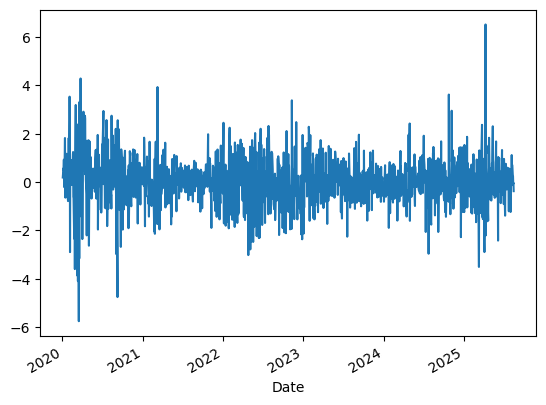

In [54]:
if not pc1.empty:
    pc1.plot()
else:
    print("No data to plot for PC1")

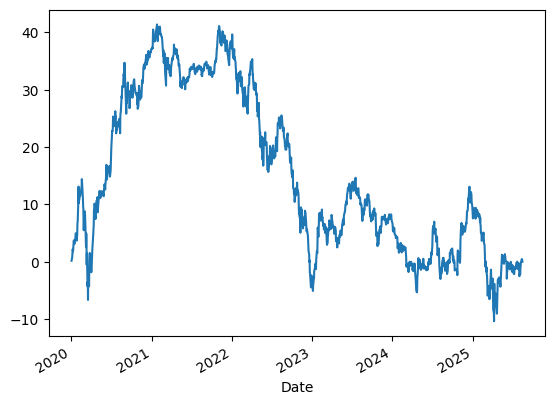

In [55]:
if not pc1.empty:
    pc1.cumsum().plot()
else:
    print("No data to plot for cumulative PC1")